In this notebook, we are going to do some simple LSTM modeling of a time series. Of course this will be financial related and will the time series of SPY. 
A couple of things that I want to try: 
* Using the keras sequential API for creating a simple LSTM model
* Using the keras functional API to create a more sophisticated model which takes different types of input


In [18]:
import pandas as pd 
import numpy as np 
import tensorflow as tf 
import yfinance as yf
import matplotlib.pyplot as plt

# Importing scikit-learn utility functions
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# Keras imports for use later 
from tensorflow.keras.models import Sequential, Model 
from tensorflow.keras.layers import Dense, LSTM
from tensorflow.keras.utils import plot_model

In [3]:
spy = yf.download(tickers='SPY', progress=False)

# We are looking at the log returns of SPY
spy_log_close = spy['Adj Close'].apply(np.log)
log_returns = spy_log_close.diff()

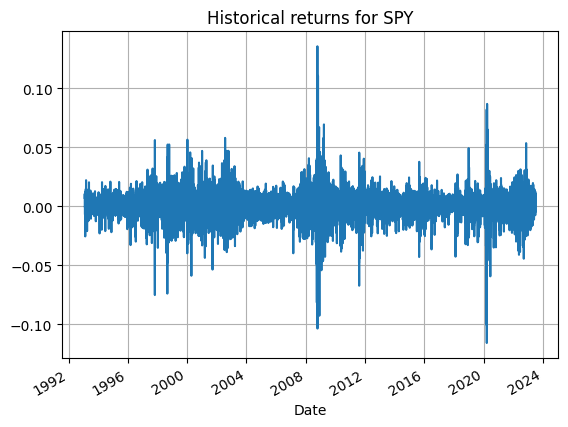

In [4]:
log_returns.plot()
plt.title("Historical returns for SPY")
plt.grid()
plt.show()

The type of model we will try is a simple LSTM model that uses the sequences of the past N days of returns to predict the next day's returns. We can also handle sequence to sequence modeling but we can use the individual return for now though. 

In [6]:
# Creating training, validation, and test data for this
target = log_returns.shift(-1)

all_data = pd.concat([log_returns, target], axis = 1).dropna()
all_data.columns = ['log_returns', 'target']

# Using the number of periods in the past to create our sequences
n_periods = 20
ts = all_data['log_returns'].copy(deep = True)

feature_array = np.array([ts.iloc[i:i+n_periods] for i in range(ts.shape[0]-n_periods+1)])
target_array = all_data['target'].iloc[n_periods-1:].values

In [7]:
# Now that we have the array, we can split these into training, validation, and test data
features_train, features_test, targets_train, targets_test = train_test_split(
    feature_array, target_array, test_size=0.2, shuffle=False
)

# Creating the validation data from the training data
val_size_pct = 0.2
val_size = int(features_train.shape[0] * val_size_pct)

features_validation = features_train[-val_size:]
targets_validation = targets_train[-val_size:]

features_train = features_train[:-val_size]
targets_train = targets_train[:-val_size]

Now that we have the features in training, validation, and testing. Let's set up our simple neural network model. One thing that I'd note is that we have not done any normalization or anything like that. We can do those in further improvements to our model. 

In [8]:
model = Sequential()
model.add(LSTM(units = 32, return_sequences=True, input_shape = (n_periods, 1)))
model.add(LSTM(units = 32, return_sequences=False))
model.add(Dense(units = 1, activation = 'linear')) 

# Then we compile this model
model.compile(
    optimizer = tf.keras.optimizers.Adam(), 
    loss = tf.keras.losses.MeanSquaredError(), 
    metrics = ['mse', 'mae']
)

2023-07-01 08:32:20.911026: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 08:32:20.912598: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 08:32:20.914034: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm (LSTM)                 (None, 20, 32)            4352      
                                                                 
 lstm_1 (LSTM)               (None, 32)                8320      
                                                                 
 dense (Dense)               (None, 1)                 33        
                                                                 
Total params: 12,705
Trainable params: 12,705
Non-trainable params: 0
_________________________________________________________________


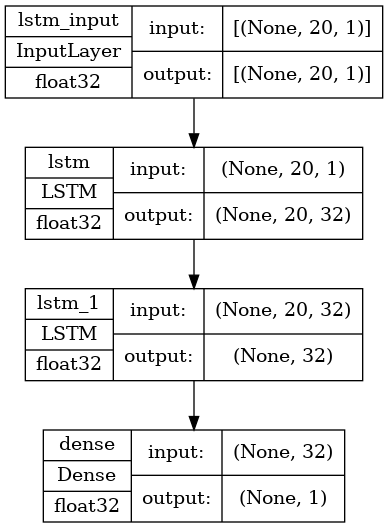

In [10]:
plot_model(model, "lstm_modeling_regression.png", show_dtype=True, show_shapes=True)

In [11]:
# Doing a quick fit of this for 30 epochs
history = model.fit(
    x = features_train, 
    y = targets_train, 
    validation_data = (features_validation, targets_validation), 
    epochs = 30
)

Epoch 1/30


2023-07-01 08:32:37.721526: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 08:32:37.722573: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 08:32:37.723925: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

151/153 [============================>.] - ETA: 0s - loss: 1.6133e-04 - mse: 1.6133e-04 - mae: 0.0087

2023-07-01 08:32:41.793805: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_2_grad/concat/split_2/split_dim' with dtype int32
	 [[{{node gradients/split_2_grad/concat/split_2/split_dim}}]]
2023-07-01 08:32:41.794607: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You must feed a value for placeholder tensor 'gradients/split_grad/concat/split/split_dim' with dtype int32
	 [[{{node gradients/split_grad/concat/split/split_dim}}]]
2023-07-01 08:32:41.796559: I tensorflow/core/common_runtime/executor.cc:1197] [/device:CPU:0] (DEBUG INFO) Executor start aborting (this does not indicate an error and you can ignore this message): INVALID_ARGUMENT: You mus

153/153 [==============================] - 5s 16ms/step - loss: 1.6077e-04 - mse: 1.6077e-04 - mae: 0.0087 - val_loss: 8.0857e-05 - val_mse: 8.0857e-05 - val_mae: 0.0071
Epoch 2/30
153/153 [==============================] - 2s 12ms/step - loss: 1.5919e-04 - mse: 1.5919e-04 - mae: 0.0086 - val_loss: 6.2711e-05 - val_mse: 6.2711e-05 - val_mae: 0.0058
Epoch 3/30
153/153 [==============================] - 2s 12ms/step - loss: 1.5738e-04 - mse: 1.5738e-04 - mae: 0.0085 - val_loss: 6.5397e-05 - val_mse: 6.5397e-05 - val_mae: 0.0059
Epoch 4/30
153/153 [==============================] - 2s 12ms/step - loss: 1.5603e-04 - mse: 1.5603e-04 - mae: 0.0085 - val_loss: 6.2479e-05 - val_mse: 6.2479e-05 - val_mae: 0.0058
Epoch 5/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5700e-04 - mse: 1.5700e-04 - mae: 0.0085 - val_loss: 6.4900e-05 - val_mse: 6.4900e-05 - val_mae: 0.0060
Epoch 6/30
153/153 [==============================] - 2s 13ms/step - loss: 1.5721e-04 - mse: 1.5721e-04 - 

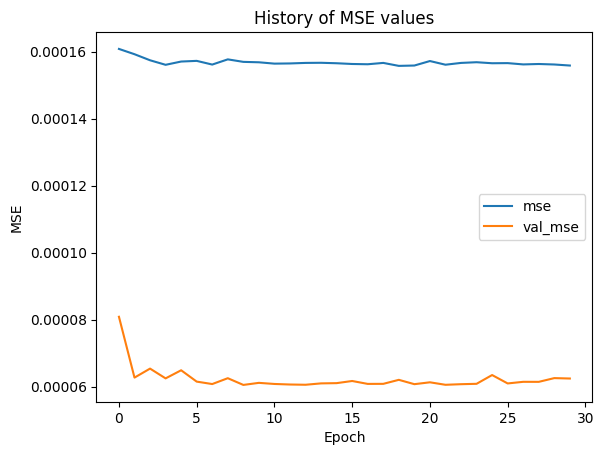

In [13]:
history_df = pd.DataFrame(history.history)
history_df[['mse', 'val_mse']].plot()
plt.title("History of MSE values")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.show()

In [16]:
test_predictions = model.predict(features_test)

48/48 [==============================] - 0s 4ms/step


In [19]:
mean_squared_error(targets_test, test_predictions.flatten())

0.00016167957029449375

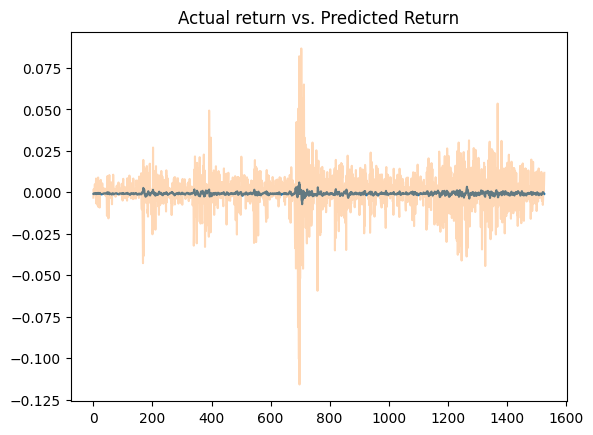

In [21]:
plt.plot(test_predictions)
plt.plot(targets_test, alpha = 0.3)
plt.title("Actual return vs. Predicted Return")
plt.show()

Conclusion: 

We set up a very quick and dirty LSTM model to try to predict the next return using some previous sequence of returns. When we look at the results, we do not see very good results I feel given that it can't pick up the magnitude in the returns at all. I think that this is a feature of not normalizing things. It's not picking up that there is conditional volatility that needs to be accounted for. This shows how the mean squared error is not super good here and does not tell the whole story. The mean absolute error can be huge here. 

Ways that we can improve on this: 
* Try out a combination model which takes other types of features such as conditonal volatility, technical indicators, etc. 
* Normalize the sequence of returns that is going into the LSTM model. That might help it a bit
* Try a classification problem maybe? Maybe it does better with that one 

We will investigate all of these things soon. 
